In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
import random

In [86]:


mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=256, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=256, shuffle=False, num_workers=2)

In [87]:
def Softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), dim=1).view(-1, 1)

In [88]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 6, 5, padding=2,stride=1), nn.Sigmoid(), nn.AvgPool2d(2,stride=2))
        self.conv2 = nn.Sequential(nn.Conv2d(6, 16, 5,padding=0,stride=1), nn.Sigmoid(), nn.AvgPool2d(2,stride=2))
        self.fc1 = nn.Sequential(nn.Linear(16*5*5, 120), nn.Sigmoid())
        self.fc2 = nn.Sequential(nn.Linear(120, 84), nn.Sigmoid())
        self.fc3 = nn.Sequential(nn.Linear(84, 10))
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return Softmax(x)


In [89]:
def train(net, train_loader, test_loader, loss, num_epochs, updater):
    loss_list = []
    train_acc_list = []
    test_acc_list = []
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        test_acc = 0
        for X, y in train_loader:
            y_hat = net(X)
            l = loss(y_hat, y)
            updater.zero_grad()
            l.backward()
            updater.step()
            train_loss += l.item()
            train_acc += (y_hat.argmax(dim=1) == y).sum().item()
        for X, y in test_loader:
            test_acc += (net(X).argmax(dim=1) == y).sum().item()
        print('epoch %d, loss %.4f, train acc %.6f, test acc %.6f'
              % (epoch + 1, train_loss / len(train_loader),
                 train_acc / len(mnist_train), test_acc / len(mnist_test)))
        loss_list.append(train_loss / len(train_loader))
        train_acc_list.append(train_acc / len(mnist_train))
        test_acc_list.append(test_acc / len(mnist_test))
    return loss_list, train_acc_list, test_acc_list
        



epoch 1, loss 2.1589, train acc 0.279083, test acc 0.594600
epoch 2, loss 1.7418, train acc 0.730233, test acc 0.856000
epoch 3, loss 1.5543, train acc 0.912467, test acc 0.937200
epoch 4, loss 1.5210, train acc 0.943067, test acc 0.954800
epoch 5, loss 1.5081, train acc 0.955217, test acc 0.967500
epoch 6, loss 1.5001, train acc 0.962483, test acc 0.960800
epoch 7, loss 1.4957, train acc 0.966967, test acc 0.964500
epoch 8, loss 1.4925, train acc 0.969783, test acc 0.971500
epoch 9, loss 1.4900, train acc 0.972183, test acc 0.971900
epoch 10, loss 1.4889, train acc 0.973217, test acc 0.978200


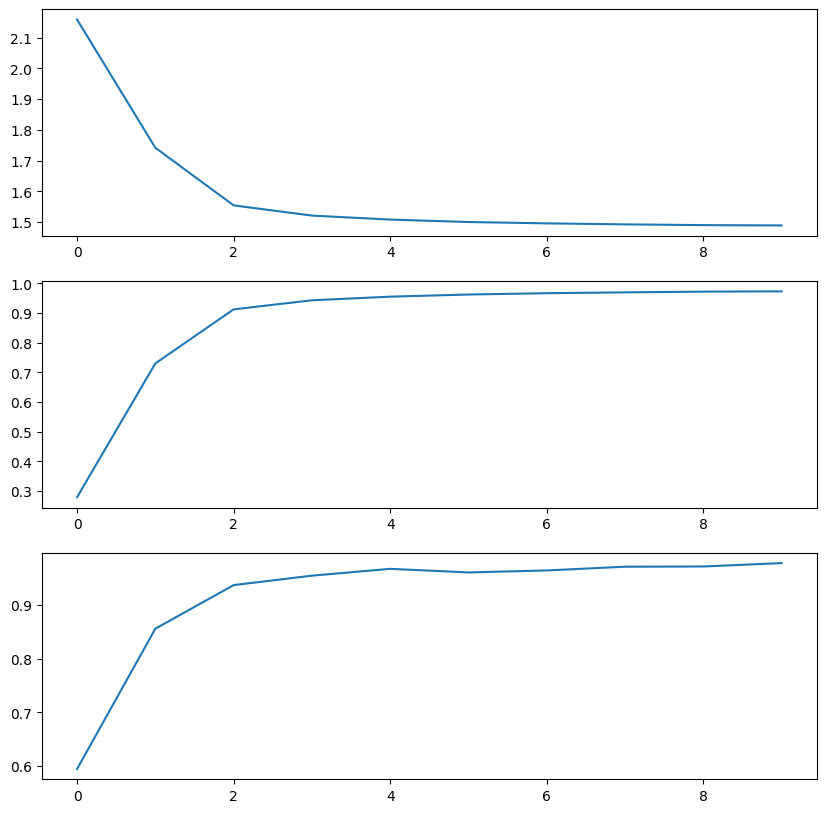

In [90]:
net = LeNet()
loss = nn.CrossEntropyLoss()
lr, num_epochs = 0.01, 10
optimizer = optim.Adam(net.parameters(), lr=lr)
loss_list, train_acc_list, test_acc_list = train(net, train_loader, test_loader, loss, num_epochs, optimizer)

#可视化损失函数，训练集准确率，测试集准确率，画在三个子图中
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.plot(loss_list)
plt.subplot(312)
plt.plot(train_acc_list)
plt.subplot(313)
plt.plot(test_acc_list)
plt.show()


In [91]:
#随机从测试集中选取10张图片，将预测结果与真实结果显示在图片上
def test(net, test_loader):
    '''测试模型，随机抽取10张图片，输出预测结果和实际结果以及图片'''
    with torch.no_grad():
        images, labels = next(iter(test_loader))
        indices = random.sample(range(len(images)), 10)
        images, labels = images[indices], labels[indices]
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(10):
            plt.imshow(images[i].squeeze(), cmap='gray')
            plt.title(f"Predicted: {predicted[i]}, Actual: {labels[i]}")
            plt.show()

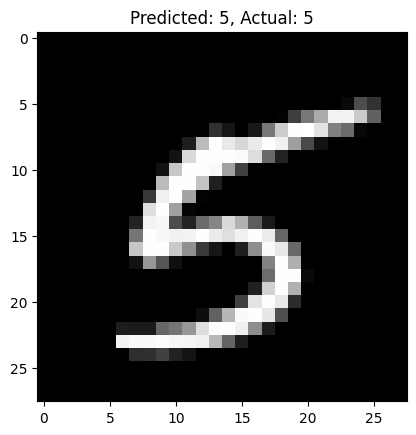

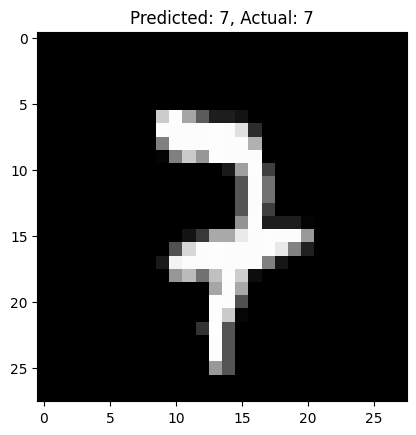

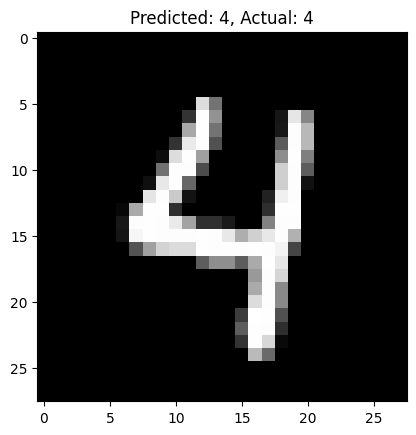

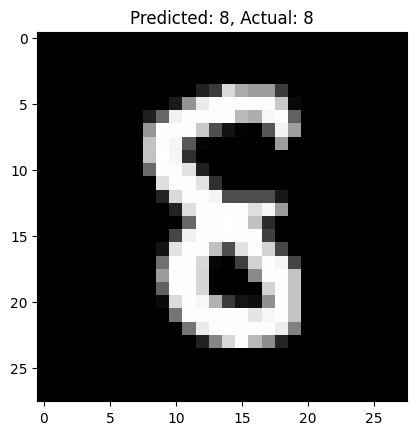

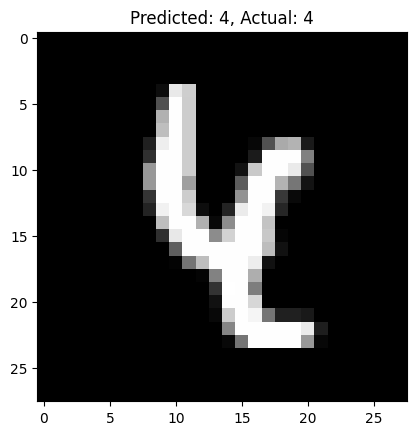

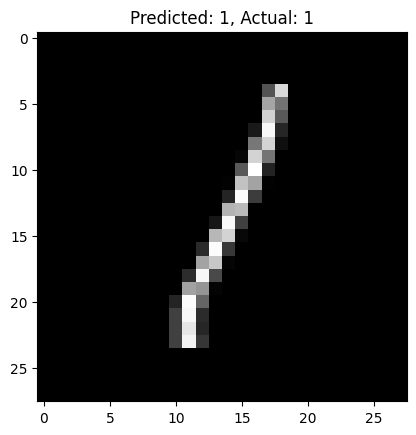

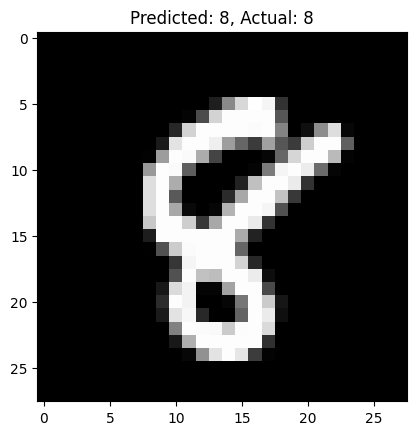

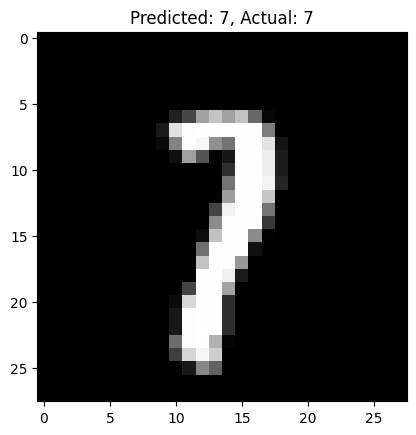

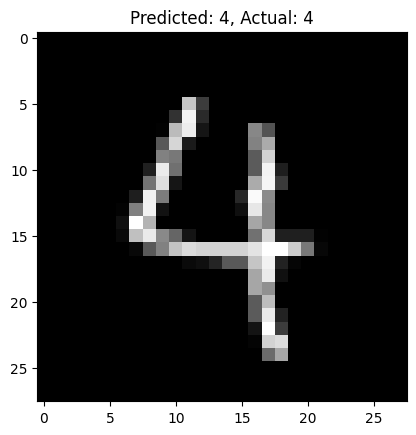

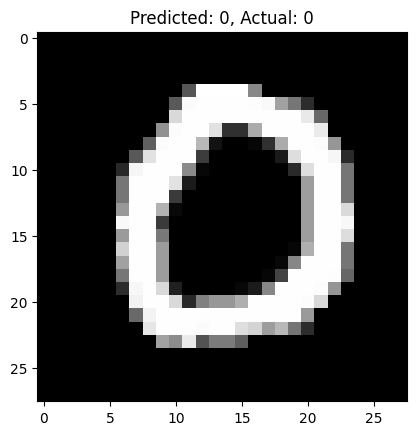

In [92]:
test(net, test_loader)